In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

In [2]:
def _get_array_from_mhd_raw_file(path):
    ds = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(ds)
    return image
def broadcast_3d_tile(matrix, h, w, d):
    m, n, o = matrix.shape[0] * h, matrix.shape[1] * w, matrix.shape[2] * d
    return np.broadcast_to(matrix.reshape(matrix.shape[0], 1, matrix.shape[1], 1, matrix.shape[2], 1),
                           (matrix.shape[0], h, matrix.shape[1], w, matrix.shape[2], d)).reshape(m, n, o)

In [3]:
path = f'''/Users/mostafa/Desktop/dsb_analyse/input/subset0'''
file_path = f'{path}/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd'
img = _get_array_from_mhd_raw_file(path=file_path)
print(img.shape)

(133, 512, 512)


I try to fit a rectangle on a slice of the 3d image. 

Also, I want each axis of the rectangle to be dividable to 35, 35 will be the size of each neighborhood for our image.

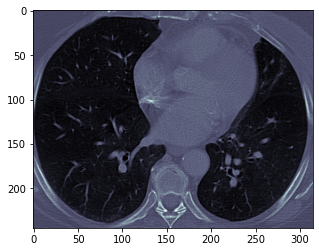

(245, 315)
Is it dividable to the neighborhoods size? True
-1024 -362.0585293164885 1794


In [4]:
data = img[70, 130:375, 115:430]
plt.imshow(data, cmap=plt.cm.bone)
plt.show()
print(data.shape)
print(f'Is it dividable to the neighborhoods size? {(data.shape[0] % 35 == 0) and (data.shape[1] % 35 == 0)}')
print(np.min(data), np.mean(data), np.max(data))

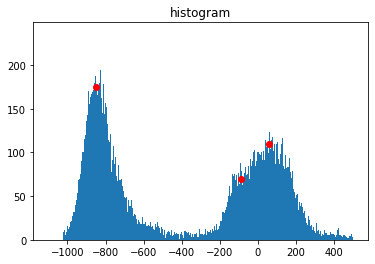

(245, 315)
-1024 -362.0585293164885 1794


In [5]:
flat = data.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-850, 175, "or")
ax.plot(-90, 70, "or")
ax.plot(60, 110, "or")
# ax.plot(310, 120, "or")
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(data), np.mean(data), np.max(data))

Now I want to check the mode of the data:

In [6]:
print(mode(data, axis=None))

ModeResult(mode=array([-1024], dtype=int16), count=array([237]))


I wonder where these values (modes) are!
I want to replace their values with some big number to brighten the relating voxels in the image.
Let's see:

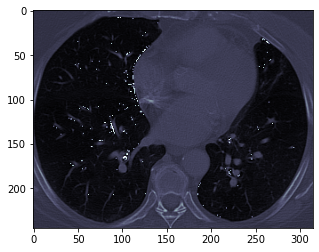

In [7]:
plt.imshow(np.where(data==-1024, 3000, data) , cmap=plt.cm.bone)
plt.show()

OK, According to the histogram, let's define our MU for J = 3 components:

iteration: 1, error: 0.00043389223222279965
iteration: 2, error: 0.0


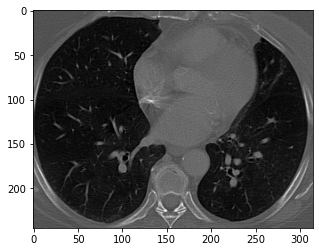

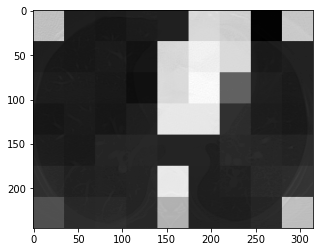

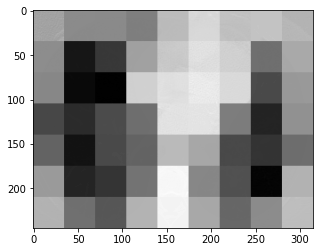

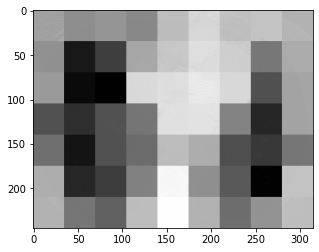

In [10]:
from ct_charachterization import run_third_algorithm


mu_5 = np.array([-870, -90, 50])
# MU = np.array([340, 240, 100, 0, -160, -370, -540, -810, -987])
# img = np.load(f'''../resources/luna_cropped.npy''')
stabilized_y = run_third_algorithm(data, mu_5, non_central=True, constant_c=10, neighborhood_size=35)
plt.imshow(data, cmap='gray')
plt.show()
for j in range(len(mu_5)):
    sy = stabilized_y[..., j]
    plt.imshow(sy, cmap='gray')
    plt.show()



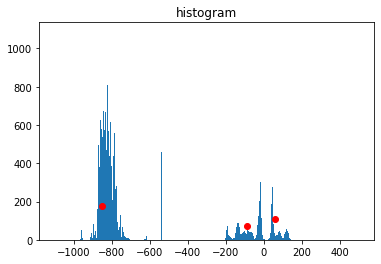

(245, 315)
-969.5135428629786 -641.9560552346262 148.9975921311625


In [13]:
flat = stabilized_y[..., 0].flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(-850, 175, "or")
ax.plot(-90, 70, "or")
ax.plot(60, 110, "or")
# ax.plot(310, 120, "or")
plt.title("histogram")
plt.show()
print(data.shape)
print(np.min(flat), np.mean(flat), np.max(flat))